## Описание проекта

 Недавно к нам обратился фермер, владелец молочного хозяйства "Вольный луг", с запросом, который касается расширения его стада коров. Фермер заключил выгодный контракт с ассоциацией пастбищ "ЭкоФерма" и теперь ему необходимо тщательно выбирать бурёнок для оптимального развития молочного хозяйства.

Наша задача - разработать две прогнозные модели машинного обучения, которые помогут фермеру принимать объективные решения о покупке коров. Каждая бурёнка должна давать не менее 6000 килограммов молока в год, и её надой должен соответствовать строгим критериям вкуса фермера. Мы получили подробные данные от ассоциации "ЭкоФерма" о их коровах, и теперь мы сосредотачиваем усилия на создании моделей, которые помогут управлять рисками и предоставят фермеру объективную информацию для принятия важных решений по покупке бурёнок.

## Загрузка данных

In [1]:
!pip install scikit-learn==0.24.1

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import statsmodels.api as sm
from scipy import stats
# создание константы RANDOM_STATE
RANDOM_STATE = 42

In [3]:
ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep = ';')
ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep = ';')
cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep = ';')

In [4]:
ferma_main.head()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет


все названия столбцов и данные соответсвуют описанным в ferma_main, но приведем названия колонок к стандтарному и удобному виду

In [5]:
columns_to_rename = {'Удой, кг' : 'yield_kg', 
                     'ЭКЕ (Энергетическая кормовая единица)': 'EKE', 
                     'Сырой протеин, г': 'row_protein_g',
                     'СПО (Сахаро-протеиновое соотношение)': 'SPO', 
                     'Порода': 'kind', 
                     'Тип пастбища': 'field_type',
                     'порода папы_быка': 'dad_kind', 
                     'Жирность,%': 'fat',
                     'Белок,%': 'protein', 
                     'Вкус молока': 'taste',
                     'Возраст': 'age'}
ferma_main.rename(columns=columns_to_rename, inplace=True)
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             634 non-null    int64 
 1   yield_kg       634 non-null    int64 
 2   EKE            634 non-null    object
 3   row_protein_g  634 non-null    int64 
 4   SPO            634 non-null    object
 5   kind           634 non-null    object
 6   field_type     634 non-null    object
 7   dad_kind       634 non-null    object
 8   fat            634 non-null    object
 9   protein        634 non-null    object
 10  taste          634 non-null    object
 11  age            634 non-null    object
dtypes: int64(3), object(9)
memory usage: 59.6+ KB


In [6]:
ferma_dad.head()

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


все названия столбцов и данные соответсвуют описанным в ferma_dad, приведем названия столбцов к стандтартным.

In [7]:
ferma_dad.rename(columns={'Имя Папы': 'dad_name'}, inplace=True)
ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   dad_name  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [8]:
cow_buy.head()

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


все названия столбцов и данные соответсвуют описанным в cow_buy, приведем названия столбцов к стандартным

In [9]:
columns_to_rename = {'Порода': 'kind',
                     'Тип пастбища': 'field_type', 
                     'порода папы_быка': 'dad_kind',
                     'Имя_папы': 'dad_name',
                     'Текущая_жирность,%': 'current_fat',
                     'Текущий_уровень_белок,%': 'current_protein',
                     'Возраст': 'age'}
cow_buy.rename(columns=columns_to_rename, inplace=True)
cow_buy.head()

,kind,field_type,dad_kind,dad_name,current_fat,current_protein,age
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


__Таким образом, после переименования всех колонок в табличках, имеем следующее, 
в таблице ferma_main:__

id - айди коровы

yield_kg - удой в кг

EKE - ЭКЕ

row_protein_g - Сырой протеин в граммах SPO - СПО

kind - порода коровы

field_type - тип пастбища

dad_kind - порода папы быка

fat - жирность в % protein - белок в %

taste - вкус молока

age - возраст коровы

__В таблице ferma_dad:__

id - айди

dad_name - Имя Папы

__В таблице cow_buy:__

kind - Порода

field_type - Тип пастбища	

dad_kind - порода папы_быка	

dad_name - Имя_папы	

current_fat	- Текущая_жирность,%	

current_protein	age - Текущий_уровень_белок,%

age - Возраст



##  Предобработка данных

**Для начала проверим таблицу ferma_main**

In [10]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             634 non-null    int64 
 1   yield_kg       634 non-null    int64 
 2   EKE            634 non-null    object
 3   row_protein_g  634 non-null    int64 
 4   SPO            634 non-null    object
 5   kind           634 non-null    object
 6   field_type     634 non-null    object
 7   dad_kind       634 non-null    object
 8   fat            634 non-null    object
 9   protein        634 non-null    object
 10  taste          634 non-null    object
 11  age            634 non-null    object
dtypes: int64(3), object(9)
memory usage: 59.6+ KB


Мы видим что пропусков нет, но в столбцах ЭКЕ, СПО, Жирность и Белок стоит тип данных object, заменим на float, а в столбцах taste и age заменим тип данных на бинарный, предварительно поменяв значения в колонках, где вкусно - 1, не вкусно - 0, Возраст более двух лет - 1, менее двух лет - 0.

In [11]:
ferma_main[['EKE', 'SPO', 'fat', 'protein']] = ferma_main[['EKE', 'SPO', 'fat', 'protein']].replace(',', '.', regex=True).astype(float)
mapingg = {'вкусно': 1, 'не вкусно': 0}
ferma_main['taste'] = ferma_main['taste'].map(mapingg)
ferma_main[['taste']] = ferma_main[['taste']].astype(bool)
maping = {'более_2_лет': 1, 'менее_2_лет': 0}
ferma_main['age'] = ferma_main['age'].map(maping)
ferma_main[['age']] = ferma_main[['age']].astype(bool)
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             634 non-null    int64  
 1   yield_kg       634 non-null    int64  
 2   EKE            634 non-null    float64
 3   row_protein_g  634 non-null    int64  
 4   SPO            634 non-null    float64
 5   kind           634 non-null    object 
 6   field_type     634 non-null    object 
 7   dad_kind       634 non-null    object 
 8   fat            634 non-null    float64
 9   protein        634 non-null    float64
 10  taste          634 non-null    bool   
 11  age            634 non-null    bool   
dtypes: bool(2), float64(4), int64(3), object(3)
memory usage: 50.9+ KB


Теперь проверим на явные и неявные дубликаты

In [12]:
ferma_main.duplicated().sum()

5

In [13]:
ferma_main = ferma_main.drop_duplicates()
ferma_main.duplicated().sum()

0

In [14]:
ferma_main['kind'].unique()

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

In [15]:
ferma_main['field_type'].unique()

array(['Равнинное', 'Равнинные', 'Холмистое'], dtype=object)

In [16]:
ferma_main['field_type'].replace('Равнинные', 'Равнинное', inplace=True)
ferma_main['field_type'].unique()

array(['Равнинное', 'Холмистое'], dtype=object)

In [17]:
ferma_main['dad_kind'].unique()

array(['Айдиал', 'Соверин', 'Айдиалл'], dtype=object)

In [18]:
ferma_main['dad_kind'].replace('Айдиалл', 'Айдиал', inplace=True)
ferma_main['dad_kind'].unique()

array(['Айдиал', 'Соверин'], dtype=object)

In [19]:
ferma_main.duplicated().sum()

0

Таким образом мы избавились от явных дубликатов (5) и нашли повторы в солбцах field_type и dad_kind и устранили их.

**Приступим к предобработке таблицы ferma_dad**

In [20]:
ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   dad_name  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [21]:
ferma_dad.duplicated().sum()

0

In [22]:
ferma_dad['dad_name'].unique()

array(['Буйный', 'Соловчик', 'Барин', 'Геркулес'], dtype=object)

Тут все хорошо, пропусков нет, дубликаты отсутсвуют.

**И предобработаем cow_buy:**

In [23]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   kind             20 non-null     object
 1   field_type       20 non-null     object
 2   dad_kind         20 non-null     object
 3   dad_name         20 non-null     object
 4   current_fat      20 non-null     object
 5   current_protein  20 non-null     object
 6   age              20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


In [24]:
cow_buy[['current_fat', 'current_protein']] = cow_buy[['current_fat', 'current_protein']].replace(',', '.', regex=True).astype(float)
cow_buy['age'] = cow_buy['age'].map(maping)
cow_buy[['age']] = cow_buy[['age']].astype(bool)
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   kind             20 non-null     object 
 1   field_type       20 non-null     object 
 2   dad_kind         20 non-null     object 
 3   dad_name         20 non-null     object 
 4   current_fat      20 non-null     float64
 5   current_protein  20 non-null     float64
 6   age              20 non-null     bool   
dtypes: bool(1), float64(2), object(4)
memory usage: 1.1+ KB


Поменяли тип данных в current_fat и current_pretein на float, age на bool

In [25]:
cow_buy.duplicated().sum()

4

In [26]:
cow_buy['field_type'].unique()

array(['холмистое', 'равнинное'], dtype=object)

In [27]:
cow_buy['field_type'].replace('равнинное', 'Равнинное', inplace=True)
cow_buy['field_type'].replace('холмистое', 'Холмистое', inplace=True)
cow_buy['field_type'].unique()

array(['Холмистое', 'Равнинное'], dtype=object)

In [28]:
cow_buy['kind'].unique()

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

In [29]:
cow_buy['dad_kind'].unique()

array(['Айдиал', 'Соверин'], dtype=object)

In [30]:
cow_buy['dad_name'].unique()

array(['Геркулес', 'Буйный', 'Барин', 'Соловчик'], dtype=object)

Пропусков нет, дубликаты удалены, тип данных изменен

**Объединим таблицы ferma_main и ferma_dad**

In [31]:
ferma = pd.merge(ferma_main, ferma_dad, on='id', how='left')
ferma.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 628
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             629 non-null    int64  
 1   yield_kg       629 non-null    int64  
 2   EKE            629 non-null    float64
 3   row_protein_g  629 non-null    int64  
 4   SPO            629 non-null    float64
 5   kind           629 non-null    object 
 6   field_type     629 non-null    object 
 7   dad_kind       629 non-null    object 
 8   fat            629 non-null    float64
 9   protein        629 non-null    float64
 10  taste          629 non-null    bool   
 11  age            629 non-null    bool   
 12  dad_name       629 non-null    object 
dtypes: bool(2), float64(4), int64(3), object(4)
memory usage: 60.2+ KB


In [32]:
ferma.head()

,id,yield_kg,EKE,row_protein_g,SPO,kind,field_type,dad_kind,fat,protein,taste,age,dad_name
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,True,True,Буйный
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,True,False,Соловчик
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,False,True,Барин
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,False,True,Буйный
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,True,False,Барин


In [33]:
ferma.duplicated().sum()

0

Таким образом мы завершили предобработку данных и можем приступать к исследовательскому анализу данных.

## Исследовательский анализ данных

In [34]:
ferma.describe()

,id,yield_kg,EKE,row_protein_g,SPO,fat,protein
count,629.00000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,315.00000,6188.750397,14.543879,1923.364070,0.913116,3.603657,3.075671
std,181.72094,1644.795489,1.306408,182.956251,0.032203,0.168656,0.002549
min,1.00000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,158.00000,5751.000000,13.500000,1771.000000,0.890000,3.590000,3.074000
50%,315.00000,6133.000000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,472.00000,6501.000000,15.600000,2062.000000,0.940000,3.720000,3.077000
max,629.00000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


**Графики для столбца 'yield_kg'**

<AxesSubplot:>

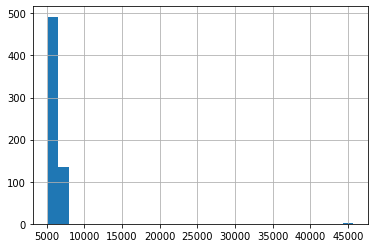

In [35]:
ferma['yield_kg'].hist(bins=30)

избавимся от аномально большого значения

In [36]:
ferma = ferma.loc[ferma['yield_kg'] != 45616]

<AxesSubplot:>

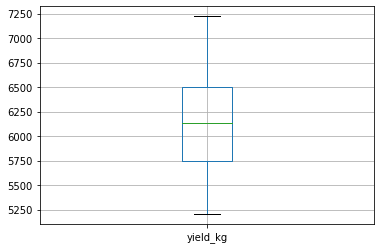

In [37]:
ferma.boxplot(column='yield_kg')

Избавились от выбросов, теперь аномально больших значений нет.

**Проверим столбец EKE**

<AxesSubplot:>

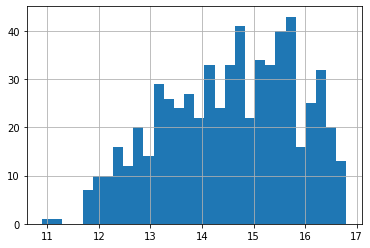

In [38]:
ferma['EKE'].hist(bins=30)

<AxesSubplot:>

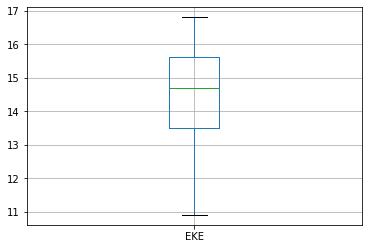

In [39]:
ferma.boxplot(column='EKE')

Выбросов нет, идем дальше

**Проверим столбец row_protein_g**

<AxesSubplot:>

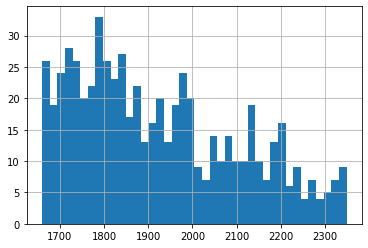

In [40]:
ferma['row_protein_g'].hist(bins=40)

<AxesSubplot:>

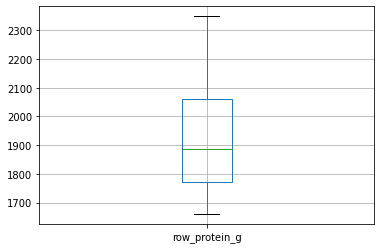

In [41]:
ferma.boxplot(column='row_protein_g')

Выбросов нет, идем дальше

**Проверим столбец SPO**

<AxesSubplot:>

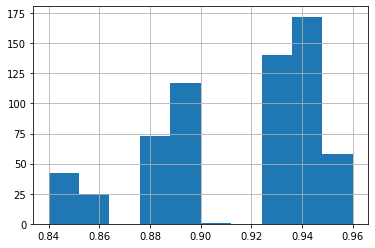

In [42]:
ferma['SPO'].hist(bins=10)

<AxesSubplot:>

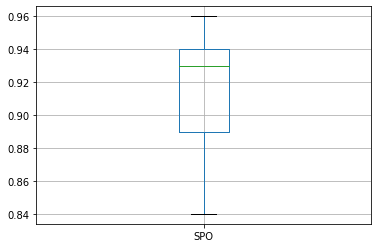

In [43]:
ferma.boxplot(column='SPO')

Выбросов нет, идем дальше

**Проверим столбец fat**

<AxesSubplot:>

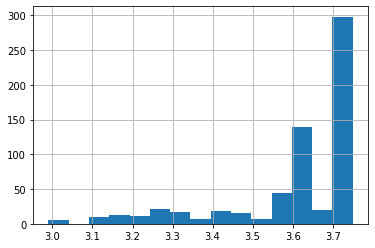

In [44]:
ferma['fat'].hist(bins=15)

<AxesSubplot:>

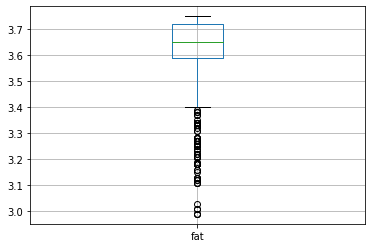

In [45]:
ferma.boxplot(column='fat')

Выбросы есть, но их слишком много и они могут повлиять на качество модели, поэтому оставим все как есть

**Рассмотрим столбец protein**

<AxesSubplot:>

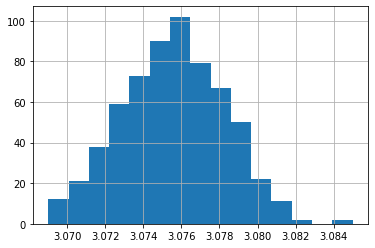

In [46]:
ferma['protein'].hist(bins=15)

<AxesSubplot:>

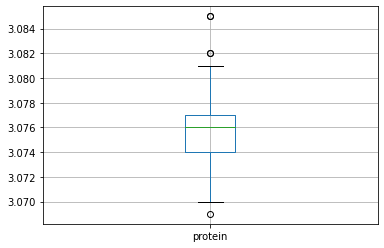

In [47]:
ferma.boxplot(column='protein')

пока оставим так

**Теперь построим графики для категориальных признаков**

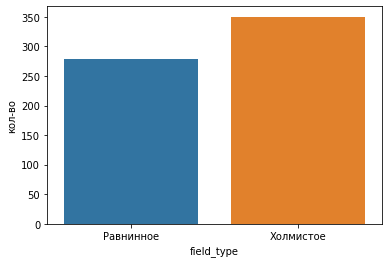

------------------------------------------------------------


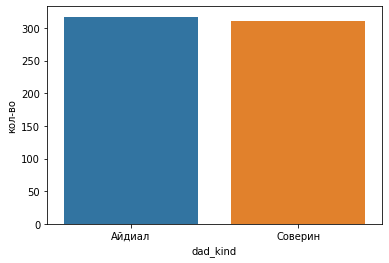

------------------------------------------------------------


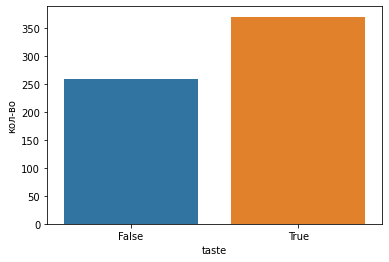

------------------------------------------------------------


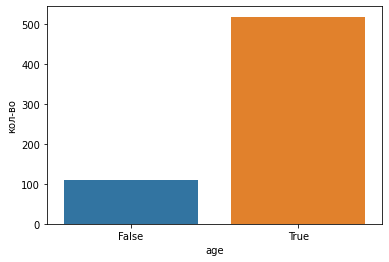

------------------------------------------------------------


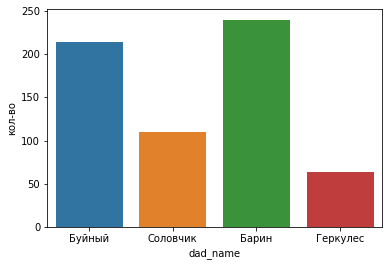

------------------------------------------------------------


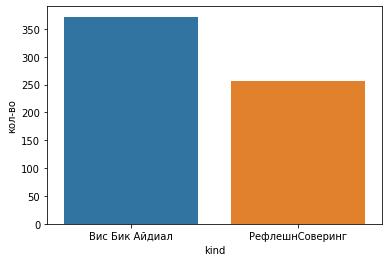

------------------------------------------------------------


In [48]:
ferma_cat = ['field_type', 'dad_kind', 'taste', 'age', 'dad_name', 'kind']
for column in ferma_cat:
    sns.countplot(x=column, data=ferma)
    plt.ylabel('кол-во')
    plt.show()
    print('------------------------------------------------------------')

мы видим что коров возраста более двух лет в 5 раз больше чем остальных, другие данные особо ничем не выделяются.

## Корреляционный анализ

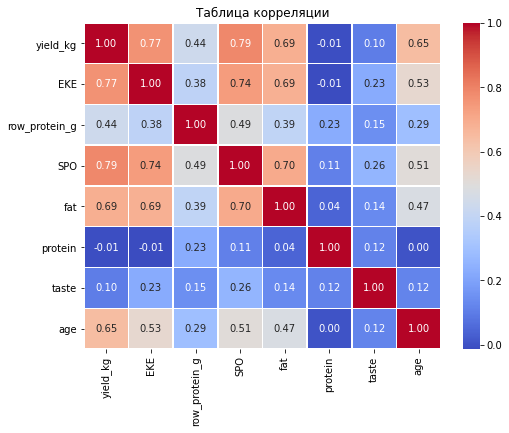

In [49]:
correlation_matrix = ferma.drop('id', axis = 1).corr(method='spearman', min_periods=1)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Таблица корреляции')
plt.show()

In [50]:
ferma.drop('id', axis = 1).corr(method='spearman', min_periods=1)

,yield_kg,EKE,row_protein_g,SPO,fat,protein,taste,age
yield_kg,1.000000,0.765144,0.437543,0.787904,0.688506,-0.005701,0.102273,0.647025
EKE,0.765144,1.000000,0.384747,0.741962,0.686973,-0.013321,0.225177,0.529561
row_protein_g,0.437543,0.384747,1.000000,0.485890,0.392822,0.229051,0.145765,0.292011
SPO,0.787904,0.741962,0.485890,1.000000,0.701044,0.109924,0.259041,0.506498
fat,0.688506,0.686973,0.392822,0.701044,1.000000,0.043125,0.135244,0.474238
protein,-0.005701,-0.013321,0.229051,0.109924,0.043125,1.000000,0.115930,0.003979
taste,0.102273,0.225177,0.145765,0.259041,0.135244,0.115930,1.000000,0.117584
age,0.647025,0.529561,0.292011,0.506498,0.474238,0.003979,0.117584,1.000000


Мы видим что удой зависит от еке - 0.77 и от спо - 0.81, построим диаграммы рассеяния.

**Построим диаграммы рассеяния scatterplot для признака Удой, кг и всех количественных признаков с учётом значения категориальных признаков.**

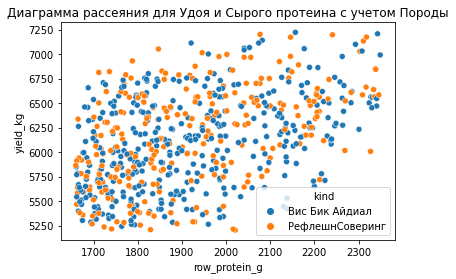

In [51]:
sns.scatterplot(x="row_protein_g", y="yield_kg", hue="kind", data=ferma)
plt.title('Диаграмма рассеяния для Удоя и Сырого протеина с учетом Породы')
plt.show()

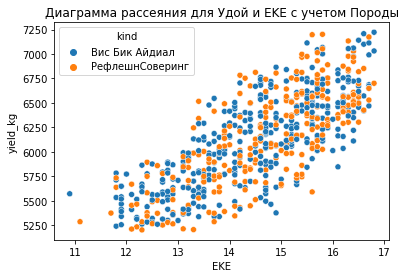

In [52]:
sns.scatterplot(x="EKE", y="yield_kg", hue="kind", data=ferma)
plt.title('Диаграмма рассеяния для Удой и EKE с учетом Породы')
plt.show()

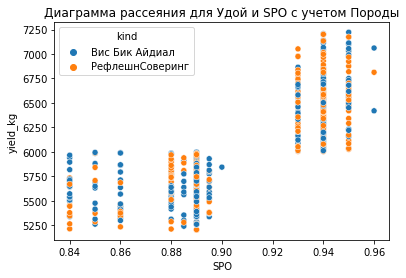

In [53]:
sns.scatterplot(x="SPO", y="yield_kg", hue="kind", data=ferma)
plt.title('Диаграмма рассеяния для Удой и SPO с учетом Породы')
plt.show()

 тут мы видим что кол-во удоя зависит от того, в каком дипазоне находится значение SPO

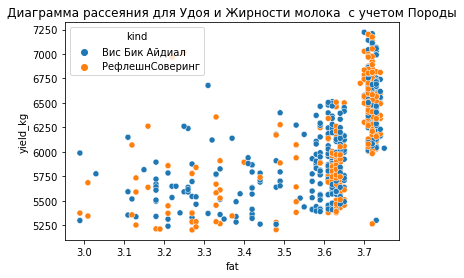

In [54]:
sns.scatterplot(x="fat", y="yield_kg", hue="kind", data=ferma)
plt.title('Диаграмма рассеяния для Удоя и Жирности молока  с учетом Породы')
plt.show()

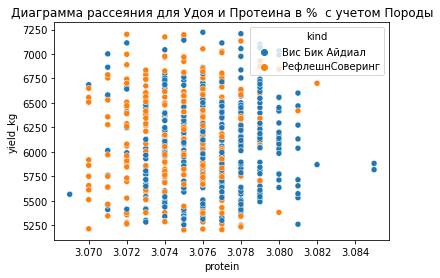

In [55]:
sns.scatterplot(x="protein", y="yield_kg", hue="kind", data=ferma)
plt.title('Диаграмма рассеяния для Удоя и Протеина в %  с учетом Породы')
plt.show()

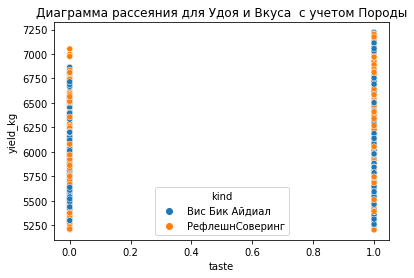

In [56]:
sns.scatterplot(x="taste", y="yield_kg", hue="kind", data=ferma)
plt.title('Диаграмма рассеяния для Удоя и Вкуса  с учетом Породы')
plt.show()

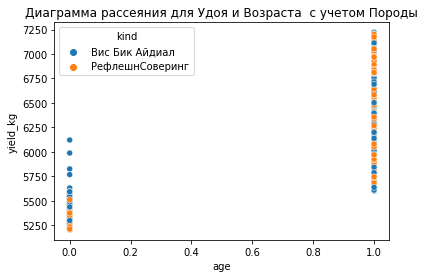

In [57]:
sns.scatterplot(x="age", y="yield_kg", hue="kind", data=ferma)
plt.title('Диаграмма рассеяния для Удоя и Возраста  с учетом Породы')
plt.show()

**Вывод:** изучив все графики и таблицу корреляции, становится ясно, что почти между всеми входными и целевыми признаками имеется линейная зависимость(Кроме протеина(ее нет вообще), а в спо мы видим что в диапазоне от 0.84 до 0.90, удоя выходит меньше 6000 кг, а если спо более 0.90, то и удой более 6000 кг, так же удой зависит от возрасте коровы, если она младше двух лет, то удоя выходят менее 6000 и наоборот)

## Обучение модели линейной регрессии

подготовим данные для обучения

In [58]:
X = ferma[['row_protein_g', 'EKE', 'SPO', 'age', 'field_type', 'dad_kind', 'kind']]
y = ferma['yield_kg']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.25,
    random_state = RANDOM_STATE)
cat_col_names = ['age', 'field_type', 'dad_kind', 'kind']
num_col_names = ['row_protein_g', 'EKE', 'SPO']

Проведем масштабирование количественных признаков

In [59]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

Закодируем категориальные признаки

In [60]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse = False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names()

создадим тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных и объедини

In [61]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [62]:
model_lr  = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [63]:
predictions = model_lr.predict(X_test)
r2 = r2_score(y_test, predictions)
print(f'R2 = {r2}')

R2 = 0.7844078173416968


**Обучим вторую модель**

Из диаграмм рассеяния мы видим что удой и спо связаны нелинейно, если значение спо менее 0.90, то и удой будет меньше 6000кг, а при значении более 0.90, удой будет больше 6000кг, поэтому преобразуем спо в категориальный признак, где 0 - менее 0.90, а 1 - более 0.90

In [64]:
ferma['spo_category'] = ferma['SPO'].apply(lambda x: 0 if x < 0.90 else 1)
ferma.tail()

,id,yield_kg,EKE,row_protein_g,SPO,kind,field_type,dad_kind,fat,protein,taste,age,dad_name,spo_category
624,625,6812,15.4,1964,0.94,РефлешнСоверинг,Равнинное,Айдиал,3.74,3.075,False,True,Буйный,1
625,626,5513,12.9,1700,0.88,РефлешнСоверинг,Равнинное,Соверин,3.64,3.073,True,False,Барин,0
626,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,False,True,Барин,0
627,628,5746,13.8,1994,0.89,РефлешнСоверинг,Равнинное,Соверин,3.64,3.077,True,True,Барин,0
628,629,6503,16.2,2283,0.94,Вис Бик Айдиал,Холмистое,Соверин,3.71,3.076,True,True,Соловчик,1


Теперь добавим новый столбец, возведя признак EKE в квадрат, что бы между удоем и эке была линейная зависимость

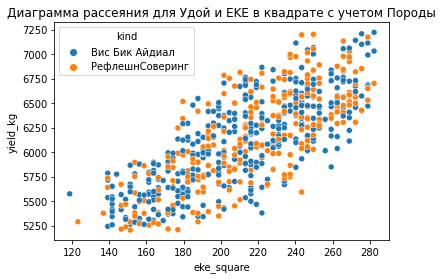

In [65]:
ferma['eke_square'] = ferma['EKE']**2
sns.scatterplot(x="eke_square", y="yield_kg", hue="kind", data=ferma)
plt.title('Диаграмма рассеяния для Удой и EKE в квадрате с учетом Породы')
plt.show()

Подготовим данные для обучения

In [66]:
X2 = ferma[['row_protein_g', 'eke_square', 'spo_category', 'field_type', 'dad_kind', 'kind']]
y2 = ferma['yield_kg']
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2,
    y2,
    test_size = 0.25,
    random_state = RANDOM_STATE)
cat_col_names2 = ['field_type', 'dad_kind', 'kind', 'spo_category']
num_col_names2 = ['row_protein_g', 'eke_square']

Проведем масштабирование количественных признаков

In [67]:
scaler2 = StandardScaler()
X_train_scaled2 = scaler2.fit_transform(X_train2[num_col_names2])
X_test_scaled2 = scaler2.transform(X_test2[num_col_names2])

In [68]:
encoder2 = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
X_train_ohe2 = encoder2.fit_transform(X_train2[cat_col_names2])
X_test_ohe2 = encoder2.transform(X_test2[cat_col_names2])
encoder_col_names2 = encoder2.get_feature_names()

In [69]:
X_train_ohe2 = pd.DataFrame(X_train_ohe2, columns=encoder_col_names2)
X_test_ohe2 = pd.DataFrame(X_test_ohe2, columns=encoder_col_names2)

X_train_scaled2 = pd.DataFrame(X_train_scaled2, columns=num_col_names2)
X_test_scaled2 = pd.DataFrame(X_test_scaled2, columns=num_col_names2)

X_train2 = pd.concat([X_train_ohe2, X_train_scaled2], axis=1)
X_test2 = pd.concat([X_test_ohe2, X_test_scaled2], axis=1)

In [70]:
model_lr2  = LinearRegression()
model_lr2.fit(X_train2, y_train2)

LinearRegression()

In [71]:
predictions2 = model_lr2.predict(X_test2)
r2_2 = r2_score(y_test2, predictions2)
print(f'R2_2 = {r2_2}')

R2_2 = 0.7818336803829982


**Обучим третью модель**

Добавим еще один признак, а именно имя папы коровы

In [72]:
X3 = ferma[['row_protein_g', 'eke_square', 'SPO', 'age', 'field_type', 'dad_kind', 'kind', 'dad_name']]
y3 = ferma['yield_kg']
X_train3, X_test3, y_train3, y_test3 = train_test_split(
    X3,
    y3,
    test_size = 0.25,
    random_state = RANDOM_STATE)
cat_col_names3 = ['age', 'field_type', 'dad_kind', 'kind', 'dad_name']
num_col_names3 = ['row_protein_g', 'eke_square', 'SPO']

In [73]:
scaler3 = StandardScaler()
X_train_scaled3 = scaler3.fit_transform(X_train3[num_col_names3])
X_test_scaled3 = scaler3.transform(X_test3[num_col_names3])

In [74]:
encoder3 = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
X_train_ohe3 = encoder3.fit_transform(X_train3[cat_col_names3])
X_test_ohe3 = encoder3.transform(X_test3[cat_col_names3])
encoder_col_names3 = encoder3.get_feature_names()

In [75]:
X_train_ohe3 = pd.DataFrame(X_train_ohe3, columns=encoder_col_names3)
X_test_ohe3 = pd.DataFrame(X_test_ohe3, columns=encoder_col_names3)

X_train_scaled3 = pd.DataFrame(X_train_scaled3, columns=num_col_names3)
X_test_scaled3 = pd.DataFrame(X_test_scaled3, columns=num_col_names3)

X_train3 = pd.concat([X_train_ohe3, X_train_scaled3], axis=1)
X_test3 = pd.concat([X_test_ohe3, X_test_scaled3], axis=1)

In [76]:
model_lr3  = LinearRegression()
model_lr3.fit(X_train3, y_train3)

LinearRegression()

In [77]:
predictions3 = model_lr3.predict(X_test3)
r2_3 = r2_score(y_test3, predictions3)
print(f'R2_3 = {r2_3}')

R2_3 = 0.8045278895830151


**Теперь проведем анализ остатков для каждой модели**

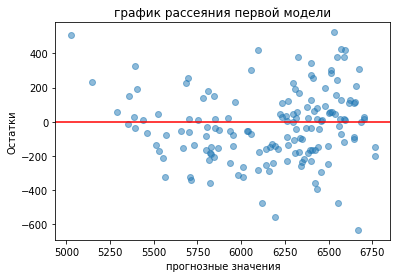

In [78]:
residuals1 = y_test - predictions
plt.scatter(predictions, residuals1, alpha=0.5)
plt.xlabel('прогнозные значения')
plt.ylabel('Остатки')
plt.title('график рассеяния первой модели')
plt.axhline(y=0, color='r', linestyle='-') # Добавляем горизонтальную линию на уровне нуля для наглядности
plt.show()

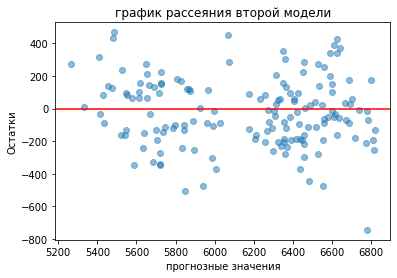

In [79]:
residuals2 = y_test2 - predictions2
plt.scatter(predictions2, residuals2, alpha=0.5)
plt.xlabel('прогнозные значения')
plt.ylabel('Остатки')
plt.title('график рассеяния второй модели')
plt.axhline(y=0, color='r', linestyle='-') # Добавляем горизонтальную линию на уровне нуля для наглядности
plt.show()

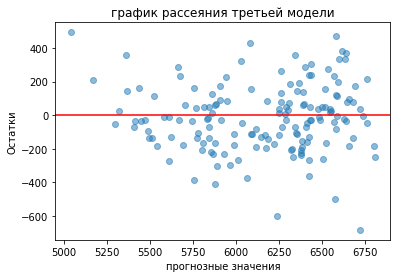

In [80]:
residuals3 = y_test3 - predictions3
plt.scatter(predictions3, residuals3, alpha=0.5)
plt.xlabel('прогнозные значения')
plt.ylabel('Остатки')
plt.title('график рассеяния третьей модели')
plt.axhline(y=0, color='r', linestyle='-') # Добавляем горизонтальную линию на уровне нуля для наглядности
plt.show()

По графикам видно, что у первых двух моделей, график образует рисунок рупора, чего не скажешь о третьей модели, где распределение нормальное.

теперь рассчитаем метрики MSE, MAE, RMSE для каждой модели

In [81]:
mse1 = mean_squared_error(y_test, predictions)
mae1 = mean_absolute_error(y_test, predictions)
rmse1 = np.sqrt(mse1)
print('Значения метрик для первой модели')
print(f'MSE: {mse1}, MAE: {mae1}, RMSE: {rmse1}')

Значения метрик для первой модели
MSE: 43887.01500966048, MAE: 164.2419446347491, RMSE: 209.49227911706072


In [82]:
mse2 = mean_squared_error(y_test2, predictions2)
mae2 = mean_absolute_error(y_test2, predictions2)
rmse2 = np.sqrt(mse2)
print('Значения метрик для Второй модели')
print(f'MSE: {mse2}, MAE: {mae2}, RMSE: {rmse2}')

Значения метрик для Второй модели
MSE: 44411.019108280256, MAE: 169.77070063694268, RMSE: 210.73922062179184


In [83]:
mse3 = mean_squared_error(y_test3, predictions3)
mae3 = mean_absolute_error(y_test3, predictions3)
rmse3 = np.sqrt(mse3)
print('Значения метрик для третьей модели')
print(f'MSE: {mse3}, MAE: {mae3}, RMSE: {rmse3}')

Значения метрик для третьей модели
MSE: 39791.273218086855, MAE: 155.14513887293617, RMSE: 199.4775005309793


Рассчитаем доверительный интервал прогноза модели:

In [84]:
np.quantile(predictions3, 0.025), np.quantile(predictions3, 0.975)

(5358.6793492741335, 6737.622470075956)

с 95% вероятностью модель прогнозирует удой от 5351 до 6737кг.

На основе р2, анализа остатков и проанализировав метрики каждой модели, мы видим, что модель под номер три является самой лучшей, поэтому именно ее мы бдем использовать для рассчета удоя

In [85]:
cow_buy.head()

,kind,field_type,dad_kind,dad_name,current_fat,current_protein,age
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,True
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,False
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,True
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,True
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,True


так как в таблце нет СПО,ЭКЕ и сырой протеин, возьмем среднее значение из таблицы ferma, увеличим их на 5 % и добавим в cow_buy

In [86]:
cow_buy['SPO'] = ferma['SPO'].mean()*1.05
cow_buy['row_protein_g'] = ferma['row_protein_g'].mean()*1.05
cow_buy['eke_square'] = (ferma['EKE'].mean()*1.05)**2

In [87]:
cow_buy.head()

,kind,field_type,dad_kind,dad_name,current_fat,current_protein,age,SPO,row_protein_g,eke_square
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,True,0.958744,2019.947532,233.361138
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,False,0.958744,2019.947532,233.361138
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,True,0.958744,2019.947532,233.361138
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,True,0.958744,2019.947532,233.361138
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,True,0.958744,2019.947532,233.361138


In [88]:
cow_buy.rename(columns={'current_fat': 'fat', 'current_protein' : 'protein'}, inplace = True)
cow_buy.head()

,kind,field_type,dad_kind,dad_name,fat,protein,age,SPO,row_protein_g,eke_square
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,True,0.958744,2019.947532,233.361138
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,False,0.958744,2019.947532,233.361138
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,True,0.958744,2019.947532,233.361138
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,True,0.958744,2019.947532,233.361138
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,True,0.958744,2019.947532,233.361138


Подготовим данные для предсказания.

In [89]:
cow_buy_scaled = scaler3.transform(cow_buy[num_col_names3])

cow_buy_encoded = encoder3.transform(cow_buy[cat_col_names3])

X_new = np.concatenate([cow_buy_scaled, cow_buy_encoded], axis=1)

predictions_cow = model_lr3.predict(X_new)

In [90]:
predictions_cow

array([6338.09291708, 6118.73036339, 5881.56239193, 6248.951799  ,
       6279.41453761, 6261.76560772, 6338.09291708, 6058.72073264,
       5881.56239193, 6308.96142975, 6131.58052094, 6201.75597697,
       6338.09291708, 5884.16222094, 5881.56239193, 6248.951799  ,
       6131.58052094, 6261.76560772, 6058.72073264, 6279.41453761])

In [91]:
cow_buy['yield_kg'] = predictions_cow

In [92]:
cow_buy

,kind,field_type,dad_kind,dad_name,fat,protein,age,SPO,row_protein_g,eke_square,yield_kg
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,True,0.958744,2019.947532,233.361138,6338.092917
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,False,0.958744,2019.947532,233.361138,6118.730363
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,True,0.958744,2019.947532,233.361138,5881.562392
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,True,0.958744,2019.947532,233.361138,6248.951799
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,True,0.958744,2019.947532,233.361138,6279.414538
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,False,0.958744,2019.947532,233.361138,6261.765608
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,True,0.958744,2019.947532,233.361138,6338.092917
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,True,0.958744,2019.947532,233.361138,6058.720733
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,True,0.958744,2019.947532,233.361138,5881.562392
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,False,0.958744,2019.947532,233.361138,6308.961430


Таким образом мы получили прогноз удоя коров

## Обучение модели логистической регрессии

In [93]:
ferma.head()

,id,yield_kg,EKE,row_protein_g,SPO,kind,field_type,dad_kind,fat,protein,taste,age,dad_name,spo_category,eke_square
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,True,True,Буйный,0,201.64
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,True,False,Соловчик,0,163.84
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,False,True,Барин,0,196.00
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,False,True,Буйный,0,153.76
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,True,False,Барин,0,163.84


Подготовим данные для обучения модели logisticRegression

In [94]:
X_clf = ferma[['kind', 'field_type', 'dad_kind', 'dad_name', 'fat', 'protein', 'age', 'eke_square', 'row_protein_g', 'SPO']]
y_clf = ferma['taste']
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf,
    y_clf,
    test_size = 0.25,
    random_state = RANDOM_STATE)
cat_clf = ['kind', 'field_type', 'dad_kind', 'dad_name', 'age']
num_clf = ['fat', 'protein', 'eke_square', 'row_protein_g', 'SPO']

In [95]:
scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf[num_clf])
X_test_clf_scaled = scaler_clf.transform(X_test_clf[num_clf])

In [96]:
encoder_clf = OneHotEncoder(handle_unknown='ignore', sparse = False)
X_train_clf_ohe = encoder_clf.fit_transform(X_train_clf[cat_clf])
X_test_clf_ohe = encoder_clf.transform(X_test_clf[cat_clf])
encoder_col_names_clf = encoder_clf.get_feature_names()

In [97]:
X_train_clf_ohe = pd.DataFrame(X_train_clf_ohe, columns=encoder_col_names_clf)
X_test_clf_ohe = pd.DataFrame(X_test_clf_ohe, columns=encoder_col_names_clf)

X_train_clf_scaled = pd.DataFrame(X_train_clf_scaled, columns=num_clf)
X_test_clf_scaled = pd.DataFrame(X_test_clf_scaled, columns=num_clf)

X_train_clf = pd.concat([X_train_clf_ohe, X_train_clf_scaled], axis=1)
X_test_clf = pd.concat([X_test_clf_ohe, X_test_clf_scaled], axis=1)

In [98]:
clf = LogisticRegression()
clf = clf.fit(X_train_clf, y_train_clf)
predictions_clf = clf.predict(X_test_clf)

Теперь рассчитаем accuracy для данной модели

In [99]:
acc = accuracy_score(y_test_clf, predictions_clf)
acc

0.6178343949044586

а также метрики recall и precision

In [100]:
recall = recall_score(y_test_clf, predictions_clf)
precision = precision_score(y_test_clf, predictions_clf)
print(f'recall: {recall}, precision: {precision}')

recall: 0.8409090909090909, precision: 0.6166666666666667


Из этого, мы можем сделать вывод, что модель слишком часто ошибается, когда присвает колонке taste Вкусно, и это проблема, так как молоко может оказаться на самом деле не вкусным, поэтому нам надо повысить метрику precision, изменив порог.

In [101]:
threshold = 0.82
# Получение вероятностей классов 
probabilities = clf.predict_proba(X_test_clf)[:, 1] 
# Применение порога к вероятностям
predictions_clf = (probabilities >= threshold).astype(int)

**я не совсем понимаю будет ли этот порог работать, когда я буду применять модель к данным**

In [102]:
recall = recall_score(y_test_clf, predictions_clf)
precision = precision_score(y_test_clf, predictions_clf)
print(f'recall: {recall}, precision: {precision}')

recall: 0.022727272727272728, precision: 1.0


теперь, когда модель с вероятностью 100 % не ошибется с присваиванием молоку taste Вкусно, можно применять ее к даннным cow_buy

In [103]:
cow_buy_scaled_clf = scaler_clf.transform(cow_buy[num_clf])

cow_buy_encoded_clf = encoder_clf.transform(cow_buy[cat_clf])

X_cow = np.concatenate([cow_buy_scaled_clf, cow_buy_encoded_clf], axis=1)

predictions_cow_clf = clf.predict(X_cow)

In [104]:
predictions_cow_clf

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

теперь добавим эти данные в таблицу cow_buy

In [105]:
cow_buy['taste'] = predictions_cow_clf
cow_buy

,kind,field_type,dad_kind,dad_name,fat,protein,age,SPO,row_protein_g,eke_square,yield_kg,taste
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,True,0.958744,2019.947532,233.361138,6338.092917,True
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,False,0.958744,2019.947532,233.361138,6118.730363,True
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,True,0.958744,2019.947532,233.361138,5881.562392,True
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,True,0.958744,2019.947532,233.361138,6248.951799,True
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,True,0.958744,2019.947532,233.361138,6279.414538,True
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,False,0.958744,2019.947532,233.361138,6261.765608,True
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,True,0.958744,2019.947532,233.361138,6338.092917,True
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,True,0.958744,2019.947532,233.361138,6058.720733,True
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,True,0.958744,2019.947532,233.361138,5881.562392,True
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,False,0.958744,2019.947532,233.361138,6308.961430,True


## Итоговые выводы

Итак, наконец можно посмотреть, каких же коров может купить себе фермер с нимиальным риском для себя

In [106]:
cow_buy.loc[(cow_buy['taste'] == True) & (cow_buy['yield_kg'] > 6000)]

,kind,field_type,dad_kind,dad_name,fat,protein,age,SPO,row_protein_g,eke_square,yield_kg,taste
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,True,0.958744,2019.947532,233.361138,6338.092917,True
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,False,0.958744,2019.947532,233.361138,6118.730363,True
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,True,0.958744,2019.947532,233.361138,6248.951799,True
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,True,0.958744,2019.947532,233.361138,6279.414538,True
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,False,0.958744,2019.947532,233.361138,6261.765608,True
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,True,0.958744,2019.947532,233.361138,6338.092917,True
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,True,0.958744,2019.947532,233.361138,6058.720733,True
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,False,0.958744,2019.947532,233.361138,6308.961430,True
10,Вис Бик Айдиал,Холмистое,Соверин,Соловчик,3.73,3.055,True,0.958744,2019.947532,233.361138,6131.580521,True
11,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.73,3.073,True,0.958744,2019.947532,233.361138,6201.755977,True


Мы видим, что это всего у 16 коров, удой более 6000 кг, а вкус - вкусный!

Что бы спрогнозировать удой, мы использовали модель линейной регрессии, всего было обучено 3 модели, самой лучшей оказалась модель 3 с точностью 80%, для этого мы добавили имя папы коровы в основную таблицу, а также отмасштабировали данные что бы точность была выше. Моедль может быть намного точнее, если добавить в нее новые данные.

А для прогноза вкуса, мы использовали модель классификации, метрика precision изначально была 58%, а нам важно что б модель определяла вкус точно, и не присваивала невкусному молоку taste вкусно, поэтому мы изменили порог на 0.82, благодаря чему precision стал равен 100%, после этого модель можно было применять к таблице для того что б узнать вкусность молока

Помимо моделей была также проведена работа по предобработке и анализу данных, что бы понять какую именно модель нужно использовать в нашем случае